# CLINT WP5: Insert geographical mask in the plots
### 2023/08/21 -

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import importlib
#from mpl_toolkits import Basemap
import CLINT001_functions as clint
importlib.reload(clint)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<module 'CLINT001_functions' from '/Users/squintu/Library/Mobile Documents/com~apple~CloudDocs/CMCC-iCloud/CLINT/CLINT001_functions.py'>

## Data

In [5]:
## DIRECTORIES
machine = 'laptop'

if machine == 'laptop':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    
if machine == 'workstation':
    modeldir = '~/Documents/CLINT-GoogleDrive/ERA5/'

In [6]:
### Read series of tmax and HWMI related to Lake Como
lchw = pd.read_csv('LakeComo_tmax_HW.csv',index_col='date')

In [7]:
### Identify 2019 heat wave

row_maxHWMI = lchw.loc[lchw['Valle_HWintensity'].idxmax()]
date2019_dt = dt.strptime(row_maxHWMI.name,"%Y-%m-%d")
date2019_ts = pd.to_datetime(date2019_dt)

In [8]:
### Lags for drivers
drivers = pd.read_csv('./metadata/drivers.csv')

In [12]:
drivers

,var,nc_var,test_nr,cluster,cluster_info,minlag,maxlag,cluster_centre_lon,cluster_centre_lat,cl_ortho_lon,...,cl_ext_W,cl_ext_E,cl_ext_S,cl_ext_N,clmask_test3,cl_nr,vmin,vmax,empty,meanlag
0,tmax,mx2t,3,EU1t,Central Europe,0,16,14.0,54.0,14.0,...,-2.0,30.0,40.0,60.0,labels7t2mEurope5.csv,1,-10.0,10.0,NaN,8
1,tmax,mx2t,3,EU2t,North Atlantic,30,41,-6.0,42.0,0.0,...,-16.0,16.0,30.0,70.0,NaN,2,-10.0,10.0,NaN,35
2,mslp,msl,3,EU1p,Mediterranean,0,8,4.0,36.0,14.0,...,-16.0,44.0,25.0,50.0,NaN,1,-20.0,20.0,NaN,4
3,mslp,msl,3,EU2p,Eastern Europe,70,86,32.0,54.0,27.0,...,10.0,44.0,46.0,65.0,NaN,2,-20.0,20.0,NaN,78
4,mslp,msl,3,WO2p,Greenland,40,61,-78.0,80.0,-45.0,...,-130.0,40.0,5.0,90.0,NaN,2,-20.0,20.0,NaN,50
5,sm,sm,3,EU1sm,Eastern Europe,0,26,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,13
6,sic,sic,3,AC1sic,North Atlantic and North Pacific,30,51,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,40


In [13]:
### Tmax as case study

var='tmax'
drivers_sub = drivers.loc[drivers['var'] == var]
y = 2019

In [14]:
drivers_row = drivers_sub.iloc[0]
targetdate_ts = date2019_ts

In [15]:
### ERA5 Temperature 2019

tx2019 = xr.open_dataset(f'{modeldir}/era5_{var}_dailyanom_{y}_cropped.nc')
#tx2019['mx2t'] = tx2019.mx2t - 273.15

In [16]:
### chunk taken from clint.set_maps_lag()
minlag = int(drivers_row['minlag'])
maxlag = int(drivers_row['maxlag'])

# Determine extremes of the date range considered, in the netcdf every day has 12:00 as hour
mintime_ts = targetdate_ts - pd.DateOffset(days = maxlag) + pd.DateOffset(hours = 12)
maxtime_ts = targetdate_ts - pd.DateOffset(days = minlag) + pd.DateOffset(hours = 12)

mintime_str = dt.strftime(mintime_ts,'%Y-%m-%d')
maxtime_str = dt.strftime(mintime_ts,'%Y-%m-%d')

In [17]:
lag = minlag
xrdf = tx2019
fig_width = 12
fig_height = 12

## Starting function

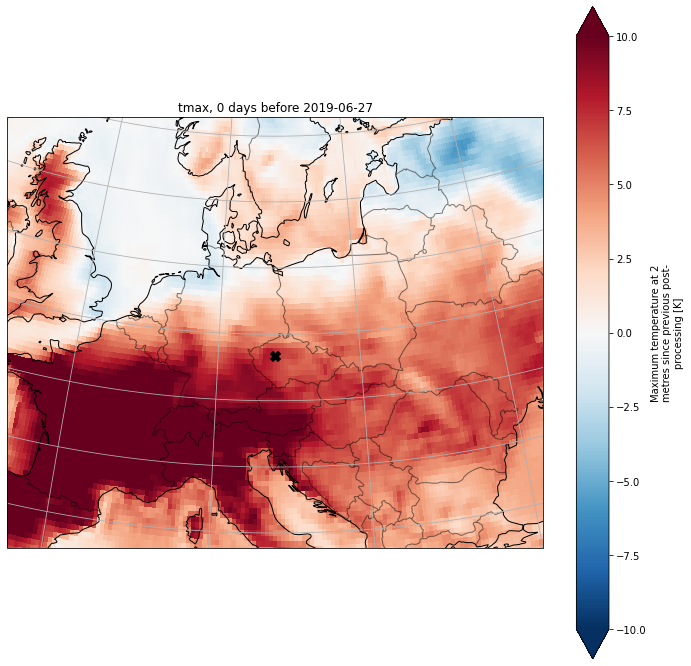

In [18]:



#if vmin == 'drivers':
vmin = drivers_row['vmin']
#if vmax == 'drivers':
vmax = drivers_row['vmax']
targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d')
var = drivers_row['var']
nc_var = drivers_row.nc_var
plotdate_ts = targetdate_ts - pd.DateOffset(days = lag)# + pd.DateOffset(hours = 12)
sub1d = xrdf.sel(time=plotdate_ts)
plt.figure(figsize=(fig_width, fig_height))

ax = plt.axes(projection=ccrs.Orthographic(central_longitude=drivers_row['cl_ortho_lon'], 
                                           central_latitude=drivers_row['cl_ortho_lat']))
ax.set_extent(drivers_row[['cl_ext_W','cl_ext_E','cl_ext_S','cl_ext_N']])    

sub1d[nc_var].plot(ax=ax, transform=ccrs.PlateCarree(),
                   cmap=plt.cm.RdBu_r, vmin = vmin, vmax = vmax)
plt.scatter(x=drivers_row['cluster_centre_lon'], y=drivers_row['cluster_centre_lon'],
            marker='X',color='black',s=100)
plt.title(f'{var}, {lag} days before {targetdate_str}')


ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
ax.gridlines()

plt.show()


## Developing function

In [19]:
## Read mask file

mask_df = pd.read_csv(f"{maskdir}{drivers_row['clmask_test3']}",index_col=[0])
cl_nr = drivers_row['cl_nr']
submask = mask_df[mask_df.cluster == cl_nr]

In [27]:
## Masks only include 2deg x 2deg grid-points
## In order to go to 0.25 deg resolution, for every point the gridpoints in a range of 1 degree are included

In [193]:
def expand_res_grid(submask_row,old_res=2,new_res=0.25):

    exp_start_lon = submask_row['nodes_lon'] - old_res/2
    exp_stop_lon = submask_row['nodes_lon'] + old_res/2 + new_res
    exp_start_lat = submask_row['nodes_lat'] - old_res/2 
    exp_stop_lat = submask_row['nodes_lat'] + old_res/2 + new_res
    
    #print([str(submask_row['nodes_lon']),str(submask_row['nodes_lat'])])
    
    exp_range_lon = np.arange(exp_start_lon,exp_stop_lon,step=new_res)
    exp_range_lat = np.arange(exp_start_lat,exp_stop_lat,step=new_res)
    add_df = pd.DataFrame([(x, y) for x in exp_range_lat for y in exp_range_lon])
    add_df.columns = ['nodes_lat','nodes_lon']
    add_df['cluster'] = cl_nr
    return (add_df)

In [194]:
def mask_xr_w_df (xrdf, submask):

    ## Generate coordinates of all gridpoints around the 2x2
    exp_list = [expand_res_grid(row) for index,row in submask.iterrows()] 
    ## Concatenate dataframes with all the new gridpoints
    exp_df = pd.concat(exp_list,ignore_index=True).reset_index(drop=True)
    ## Append the new gridpoints to the original 2x2 mask
    submask_exp = pd.concat([submask,exp_df],ignore_index=True).drop_duplicates().reset_index(drop=True)

    mask = submask_exp.assign(flag=1).set_index(["nodes_lon", "nodes_lat"]).flag.to_xarray().fillna(0).rename({"nodes_lon": "longitude", "nodes_lat": "latitude"})

    mask = mask.reindex(longitude=xrdf.longitude, latitude=xrdf.latitude,method="nearest", tolerance=1e-9, fill_value=0)

    sub_xrdf = xrdf.where(mask)
    return(sub_xrdf)

<xarray.Dataset>
Dimensions:    (time: 365, bnds: 2, longitude: 701, latitude: 241)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * longitude  (longitude) float32 -130.0 -129.8 -129.5 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 30.5 30.25 30.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, longitude, latitude) datetime64[ns] NaT NaT ... NaT
    mx2t       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Aug 16 14:41:23 2023: cdo -b 32 -ydaysub /work/csp/as18...
    frequency:    day
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

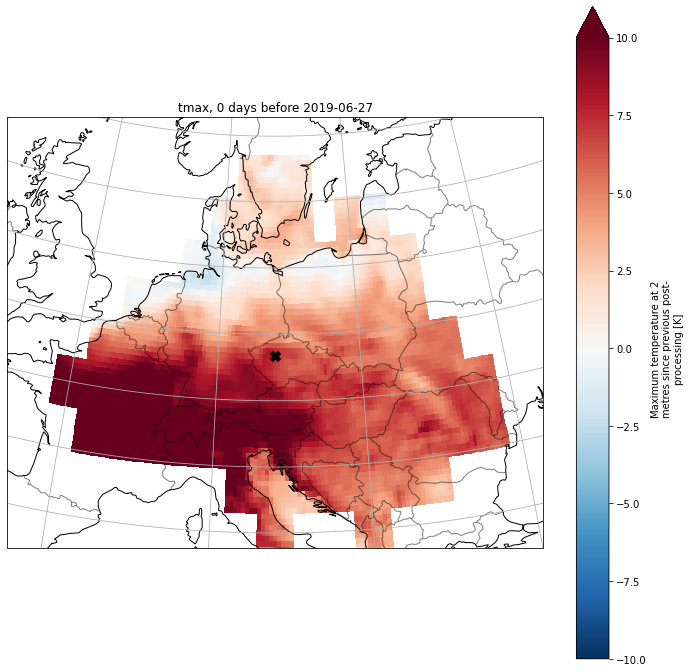

In [189]:
#if vmin == 'drivers':
vmin = drivers_row['vmin']
#if vmax == 'drivers':
vmax = drivers_row['vmax']
targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d')
var = drivers_row['var']
nc_var = drivers_row.nc_var
plotdate_ts = targetdate_ts - pd.DateOffset(days = lag)# + pd.DateOffset(hours = 12)
sub1d = sub_xrdf.sel(time=plotdate_ts)
plt.figure(figsize=(fig_width, fig_height))

ax = plt.axes(projection=ccrs.Orthographic(central_longitude=drivers_row['cl_ortho_lon'], 
                                           central_latitude=drivers_row['cl_ortho_lat']))
ax.set_extent(drivers_row[['cl_ext_W','cl_ext_E','cl_ext_S','cl_ext_N']])    

sub1d[nc_var].plot(ax=ax, transform=ccrs.PlateCarree(),
                   cmap=plt.cm.RdBu_r, vmin = vmin, vmax = vmax)
plt.scatter(x=drivers_row['cluster_centre_lon'], y=drivers_row['cluster_centre_lon'],
            marker='X',color='black',s=100)
plt.title(f'{var}, {lag} days before {targetdate_str}')


ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
ax.gridlines()

plt.show()